<div style="margin-bottom: 32px;">
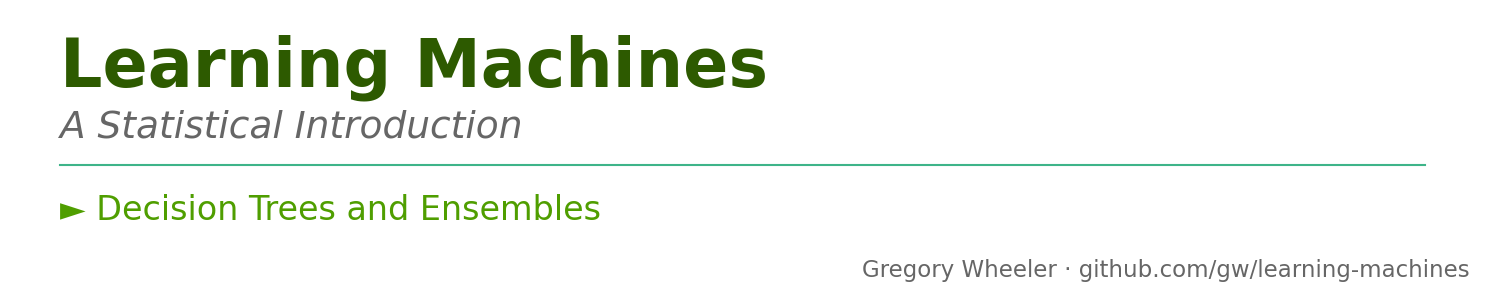
</div>


# Decision Trees and Ensemble Methods

Trees partition the feature space into rectangular regions, making decisions through a sequence of yes/no questions. This notebook visualizes how trees grow, why they overfit, and how ensembles—random forests and gradient boosting—combine many weak trees into strong predictors.

**What computation adds**: A single diagram shows one tree; here we watch splits form, see how depth controls complexity, and observe ensembles averaging out individual tree errors.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
import sys
from pathlib import Path

# Add the notebook directory to path for imports
sys.path.insert(0, str(Path.cwd()))

# Import our custom theme
import mlone_theme as mt

# Apply the style and set notebook mode (green palette)
plt.style.use('mlone_style.mplstyle')
mt.set_notebook_mode()

np.random.seed(42)

## 1. The Idea: Recursive Partitioning

A decision tree splits the feature space with axis-aligned cuts. At each node, we ask: "Is feature $x_j$ greater than threshold $t$?" The answer sends us left or right until we reach a leaf, which holds a prediction.

Let's generate a simple 2D classification problem to visualize this.

In [ ]:
def generate_classification_data(n_samples=200, seed=42):
    """Generate 2D classification data with a nonlinear boundary."""
    np.random.seed(seed)
    
    X = np.random.randn(n_samples, 2)
    # Nonlinear boundary: y = 1 if x1 + x2 > 0.5 or x1 - x2 > 1
    y = ((X[:, 0] + X[:, 1] > 0.5) | (X[:, 0] - X[:, 1] > 1.0)).astype(int)
    
    return X, y

X, y = generate_classification_data(300)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[y==0, 0], X[y==0, 1], c=mt.BLUE, s=50, alpha=0.7,
           label='Class 0', edgecolors='white', linewidths=0.5)
ax.scatter(X[y==1, 0], X[y==1, 1], c=mt.RED, s=50, alpha=0.7,
           label='Class 1', edgecolors='white', linewidths=0.5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Classification Data', fontweight='bold', loc='left')
ax.legend(loc='upper left')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Impurity Measures

To decide where to split, we measure node **impurity**—how mixed the classes are. Two common measures:

**Gini impurity**:
$$G = 1 - \sum_{k=1}^{K} p_k^2$$

**Entropy**:
$$H = -\sum_{k=1}^{K} p_k \log_2 p_k$$

Both are zero when all samples belong to one class (pure node) and maximal when classes are equally mixed.

In [ ]:
def gini(p):
    """Gini impurity for binary classification."""
    return 1 - p**2 - (1-p)**2

def entropy(p):
    """Entropy for binary classification."""
    if p == 0 or p == 1:
        return 0
    return -p * np.log2(p) - (1-p) * np.log2(1-p)

def misclassification(p):
    """Misclassification error."""
    return 1 - max(p, 1-p)

p_range = np.linspace(0.001, 0.999, 200)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(p_range, [gini(p) for p in p_range], c=mt.GREEN, linewidth=2.5, label='Gini')
ax.plot(p_range, [entropy(p)/2 for p in p_range], c=mt.BLUE, linewidth=2.5, label='Entropy / 2')
ax.plot(p_range, [misclassification(p) for p in p_range], c=mt.GRAY, linewidth=2.5, 
        linestyle='--', label='Misclassification')

ax.axvline(x=0.5, color=mt.GRAY, linestyle=':', alpha=0.5)
ax.set_xlabel('Proportion of Class 1 ($p$)')
ax.set_ylabel('Impurity')
ax.set_title('Impurity Measures for Binary Classification', fontweight='bold', loc='left')
ax.legend(loc='upper right')
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.55)

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

All three measures are concave with maximum at $p = 0.5$. Gini and entropy are nearly identical in practice; both penalize mixed nodes and reward pure ones.

## 3. Building a Decision Tree

We'll implement a simple decision tree from scratch to see how splits are chosen.

In [ ]:
class DecisionNode:
    """A node in a decision tree."""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature      # Feature index for splitting
        self.threshold = threshold  # Threshold value
        self.left = left            # Left subtree (feature <= threshold)
        self.right = right          # Right subtree (feature > threshold)
        self.value = value          # Prediction (for leaf nodes)


class DecisionTreeClassifier:
    """A simple decision tree for binary classification."""
    
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
    
    def _gini(self, y):
        """Compute Gini impurity."""
        if len(y) == 0:
            return 0
        p = np.mean(y)
        return 1 - p**2 - (1-p)**2
    
    def _best_split(self, X, y):
        """Find the best feature and threshold to split on."""
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        
        current_impurity = self._gini(y)
        n = len(y)
        
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue
                
                # Weighted impurity after split
                left_impurity = self._gini(y[left_mask])
                right_impurity = self._gini(y[right_mask])
                weighted_impurity = (left_mask.sum() * left_impurity + 
                                     right_mask.sum() * right_impurity) / n
                
                gain = current_impurity - weighted_impurity
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        """Recursively build the tree."""
        # Stopping conditions
        if (self.max_depth is not None and depth >= self.max_depth) or \
           len(y) < self.min_samples_split or \
           len(np.unique(y)) == 1:
            # Return leaf with majority class
            return DecisionNode(value=int(np.mean(y) >= 0.5))
        
        feature, threshold, gain = self._best_split(X, y)
        
        if gain <= 0:
            return DecisionNode(value=int(np.mean(y) >= 0.5))
        
        left_mask = X[:, feature] <= threshold
        left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._build_tree(X[~left_mask], y[~left_mask], depth + 1)
        
        return DecisionNode(feature=feature, threshold=threshold, left=left, right=right)
    
    def fit(self, X, y):
        """Fit the decision tree."""
        self.root = self._build_tree(X, y)
        return self
    
    def _predict_single(self, x, node):
        """Predict for a single sample."""
        if node.value is not None:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)
    
    def predict(self, X):
        """Predict for multiple samples."""
        return np.array([self._predict_single(x, self.root) for x in X])

## 4. Visualizing Tree Decisions

Let's train trees of different depths and see how they partition the space.

In [ ]:
def plot_decision_boundary(ax, model, X, y, title):
    """Plot decision boundary for a classifier."""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap([mt.BLUE, mt.RED]))
    ax.contour(xx, yy, Z, colors='black', linewidths=0.5, alpha=0.5)
    
    ax.scatter(X[y==0, 0], X[y==0, 1], c=mt.BLUE, s=30, alpha=0.7, edgecolors='white', linewidths=0.5)
    ax.scatter(X[y==1, 0], X[y==1, 1], c=mt.RED, s=30, alpha=0.7, edgecolors='white', linewidths=0.5)
    
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(title, fontweight='bold')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

depths = [1, 2, 4, None]
titles = ['Depth 1 (stump)', 'Depth 2', 'Depth 4', 'No limit (overfit)']

for ax, depth, title in zip(axes, depths, titles):
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X, y)
    acc = np.mean(tree.predict(X) == y)
    plot_decision_boundary(ax, tree, X, y, f"{title}\nTrain acc: {acc:.1%}")
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')

plt.tight_layout()
plt.show()

**Key observations:**
- Depth 1 (a "stump") makes just one split—too simple
- Moderate depth captures the main structure
- Unlimited depth creates jagged boundaries that memorize training noise

## 5. The Overfitting Problem

Deep trees overfit. Let's see this with train/test error.

In [ ]:
# Generate train and test sets
X_train, y_train = generate_classification_data(200, seed=42)
X_test, y_test = generate_classification_data(200, seed=123)

depths = range(1, 16)
train_errors = []
test_errors = []

for d in depths:
    tree = DecisionTreeClassifier(max_depth=d)
    tree.fit(X_train, y_train)
    train_errors.append(1 - np.mean(tree.predict(X_train) == y_train))
    test_errors.append(1 - np.mean(tree.predict(X_test) == y_test))

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(depths, train_errors, 'o-', c=mt.GREEN, linewidth=2, markersize=6, label='Training error')
ax.plot(depths, test_errors, 's-', c=mt.RED, linewidth=2, markersize=6, label='Test error')

ax.set_xlabel('Tree Depth')
ax.set_ylabel('Error Rate')
ax.set_title('Decision Tree: Depth vs Error', fontweight='bold', loc='left')
ax.legend(loc='upper right')
ax.set_ylim(0, 0.35)

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

Training error drops to zero as depth increases, but test error rises—classic overfitting. Single trees are high-variance models.

---

## 6. Random Forests: Averaging Reduces Variance

**Random forests** address overfitting by training many trees on different data and averaging their predictions. Two sources of randomness:

1. **Bagging**: Each tree trains on a bootstrap sample (random sample with replacement)
2. **Feature randomness**: At each split, consider only a random subset of features

This decorrelates the trees—their errors don't all go in the same direction.

In [ ]:
class RandomForestClassifier:
    """A simple random forest classifier."""
    
    def __init__(self, n_trees=10, max_depth=None, max_features='sqrt'):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
        self.feature_indices = []  # Which features each tree uses
    
    def fit(self, X, y):
        """Fit the random forest."""
        n_samples, n_features = X.shape
        
        # Determine number of features per tree
        if self.max_features == 'sqrt':
            max_f = int(np.sqrt(n_features))
        elif self.max_features == 'all':
            max_f = n_features
        else:
            max_f = min(self.max_features, n_features)
        
        max_f = max(1, max_f)  # At least one feature
        
        for _ in range(self.n_trees):
            # Bootstrap sample
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_boot = X[indices]
            y_boot = y[indices]
            
            # Random feature subset
            feat_idx = np.random.choice(n_features, size=max_f, replace=False)
            
            # Train tree on bootstrap sample with feature subset
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(X_boot[:, feat_idx], y_boot)
            
            self.trees.append(tree)
            self.feature_indices.append(feat_idx)
        
        return self
    
    def predict(self, X):
        """Predict by majority vote."""
        predictions = np.zeros((len(X), self.n_trees))
        
        for i, (tree, feat_idx) in enumerate(zip(self.trees, self.feature_indices)):
            predictions[:, i] = tree.predict(X[:, feat_idx])
        
        # Majority vote
        return (predictions.mean(axis=1) >= 0.5).astype(int)

In [ ]:
# Compare single tree vs random forest
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))

# Single deep tree
tree = DecisionTreeClassifier(max_depth=10)
tree.fit(X_train, y_train)
test_acc_tree = np.mean(tree.predict(X_test) == y_test)
plot_decision_boundary(axes[0], tree, X_train, y_train, 
                       f'Single Tree (depth=10)\nTest acc: {test_acc_tree:.1%}')

# Random forest with shallow trees
rf_shallow = RandomForestClassifier(n_trees=50, max_depth=3, max_features='all')
rf_shallow.fit(X_train, y_train)
test_acc_rf_shallow = np.mean(rf_shallow.predict(X_test) == y_test)
plot_decision_boundary(axes[1], rf_shallow, X_train, y_train,
                       f'Forest: 50 trees, depth=3\nTest acc: {test_acc_rf_shallow:.1%}')

# Random forest with deep trees
rf_deep = RandomForestClassifier(n_trees=50, max_depth=10, max_features='sqrt')
rf_deep.fit(X_train, y_train)
test_acc_rf_deep = np.mean(rf_deep.predict(X_test) == y_test)
plot_decision_boundary(axes[2], rf_deep, X_train, y_train,
                       f'Forest: 50 trees, depth=10\nTest acc: {test_acc_rf_deep:.1%}')

for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')

plt.tight_layout()
plt.show()

The random forest decision boundary is smoother—averaging many jagged boundaries produces a more stable result.

## 7. How Many Trees?

More trees generally help, with diminishing returns. Unlike tree depth, more trees don't cause overfitting—they reduce variance without increasing bias.

In [ ]:
n_trees_range = [1, 2, 5, 10, 20, 50, 100, 200]
test_errors_rf = []

for n_trees in n_trees_range:
    rf = RandomForestClassifier(n_trees=n_trees, max_depth=8, max_features='sqrt')
    rf.fit(X_train, y_train)
    test_errors_rf.append(1 - np.mean(rf.predict(X_test) == y_test))

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(n_trees_range, test_errors_rf, 'o-', c=mt.GREEN, linewidth=2.5, markersize=8)

ax.set_xlabel('Number of Trees')
ax.set_ylabel('Test Error Rate')
ax.set_title('Random Forest: More Trees, Lower Variance', fontweight='bold', loc='left')
ax.set_xscale('log')

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

---

## 8. Gradient Boosting: Sequential Correction

**Boosting** takes a different approach: train trees *sequentially*, where each new tree corrects the errors of the previous ensemble.

In **gradient boosting**, each tree fits the *residuals* (or pseudo-residuals for classification). We add trees with a small learning rate to avoid overshooting.

In [ ]:
# For simplicity, we'll use regression trees on the residuals
# This is gradient boosting for regression, which illustrates the core idea

def generate_regression_data(n_samples=100, seed=42):
    """Generate 1D regression data."""
    np.random.seed(seed)
    x = np.linspace(0, 10, n_samples)
    y = np.sin(x) + 0.3 * np.random.randn(n_samples)
    return x.reshape(-1, 1), y

X_reg, y_reg = generate_regression_data(100)

class DecisionTreeRegressor:
    """Simple regression tree."""
    
    def __init__(self, max_depth=2):
        self.max_depth = max_depth
        self.root = None
    
    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.var(y)
    
    def _best_split(self, X, y):
        best_gain = -np.inf
        best_feature = 0
        best_threshold = 0
        
        current_mse = self._mse(y)
        n = len(y)
        
        for feature in range(X.shape[1]):
            thresholds = np.percentile(X[:, feature], np.linspace(10, 90, 20))
            
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                if left_mask.sum() < 2 or (~left_mask).sum() < 2:
                    continue
                
                weighted_mse = (left_mask.sum() * self._mse(y[left_mask]) + 
                               (~left_mask).sum() * self._mse(y[~left_mask])) / n
                gain = current_mse - weighted_mse
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(y) < 4:
            return DecisionNode(value=np.mean(y))
        
        feature, threshold, gain = self._best_split(X, y)
        
        if gain <= 0:
            return DecisionNode(value=np.mean(y))
        
        left_mask = X[:, feature] <= threshold
        left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._build_tree(X[~left_mask], y[~left_mask], depth + 1)
        
        return DecisionNode(feature=feature, threshold=threshold, left=left, right=right)
    
    def fit(self, X, y):
        self.root = self._build_tree(X, y)
        return self
    
    def _predict_single(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_single(x, node.left)
        return self._predict_single(x, node.right)
    
    def predict(self, X):
        return np.array([self._predict_single(x, self.root) for x in X])

In [ ]:
# Gradient boosting visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

learning_rate = 0.3
n_rounds = 8
predictions = np.zeros(len(y_reg))
trees = []

x_plot = np.linspace(0, 10, 200).reshape(-1, 1)

for i in range(n_rounds):
    ax = axes[i // 4, i % 4]
    
    # Current residuals
    residuals = y_reg - predictions
    
    # Fit tree to residuals
    tree = DecisionTreeRegressor(max_depth=2)
    tree.fit(X_reg, residuals)
    trees.append(tree)
    
    # Update predictions
    predictions += learning_rate * tree.predict(X_reg)
    
    # Compute predictions on plot grid
    y_plot = np.zeros(len(x_plot))
    for j, t in enumerate(trees):
        y_plot += learning_rate * t.predict(x_plot)
    
    # Plot
    ax.scatter(X_reg, y_reg, c=mt.GRAY, s=30, alpha=0.5, edgecolors='none')
    ax.plot(x_plot, y_plot, c=mt.GREEN, linewidth=2.5)
    ax.plot(x_plot, np.sin(x_plot), c=mt.BLUE, linewidth=2, linestyle='--', alpha=0.5)
    
    mse = np.mean((y_reg - predictions)**2)
    ax.set_title(f'Round {i+1}: MSE = {mse:.3f}', fontweight='bold')
    ax.set_xlim(0, 10)
    ax.set_ylim(-2, 2)
    
    mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

Each round, the ensemble gets closer to the true function. The shallow trees (stumps) individually are weak, but together they approximate complex functions.

## 9. Bagging vs Boosting

| Aspect | Bagging (Random Forest) | Boosting |
|--------|------------------------|----------|
| Training | Parallel (independent trees) | Sequential (each tree corrects errors) |
| Tree depth | Often deep | Often shallow (stumps) |
| Main effect | Reduces variance | Reduces bias |
| Overfitting risk | Low | Higher (needs early stopping) |
| Hyperparameters | n_trees, max_features | n_rounds, learning_rate, max_depth |

## 10. Feature Importance

Trees provide a natural measure of feature importance: how much does each feature reduce impurity across all splits?

For random forests, we average importance across all trees.

In [ ]:
# Generate data with clear feature importance structure
np.random.seed(42)
n = 300
X_imp = np.random.randn(n, 5)  # 5 features
# Only features 0 and 2 matter
y_imp = ((X_imp[:, 0] > 0) ^ (X_imp[:, 2] > 0.5)).astype(int)

# Use sklearn for feature importance (our simple implementation doesn't track this)
from sklearn.ensemble import RandomForestClassifier as SklearnRF

rf_sklearn = SklearnRF(n_estimators=100, max_depth=5, random_state=42)
rf_sklearn.fit(X_imp, y_imp)

importances = rf_sklearn.feature_importances_
feature_names = [f'Feature {i}' for i in range(5)]

fig, ax = plt.subplots(figsize=(8, 5))

colors = [mt.GREEN if i in [0, 2] else mt.GRAY for i in range(5)]
bars = ax.barh(feature_names, importances, color=colors, edgecolor='white', linewidth=1.5)

ax.set_xlabel('Importance (mean impurity decrease)')
ax.set_title('Feature Importance in Random Forest', fontweight='bold', loc='left')

# Add annotation
ax.annotate('True predictors', xy=(importances[0], 0), xytext=(0.35, 1),
            fontsize=11, color=mt.GREEN,
            arrowprops=dict(arrowstyle='->', color=mt.GREEN, lw=1.5))

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

## 11. Production Libraries

Our from-scratch implementations illustrate the algorithms, but production code uses optimized libraries. Let's compare with scikit-learn.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# Use the same data from earlier sections
# Create a fresh classification dataset
np.random.seed(123)
X_compare = np.random.randn(500, 4)
y_compare = ((X_compare[:, 0] > 0) & (X_compare[:, 1] > 0) | 
             (X_compare[:, 0] < 0) & (X_compare[:, 1] < 0)).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_compare, y_compare, test_size=0.3, random_state=42
)

# sklearn Random Forest
sklearn_rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
sklearn_rf.fit(X_train, y_train)
rf_acc = sklearn_rf.score(X_test, y_test)

# sklearn Gradient Boosting  
sklearn_gb = GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42)
sklearn_gb.fit(X_train, y_train)
gb_acc = sklearn_gb.score(X_test, y_test)

print(f"sklearn Random Forest accuracy:     {rf_acc:.3f}")
print(f"sklearn Gradient Boosting accuracy: {gb_acc:.3f}")

**Production alternatives:**

- **XGBoost** and **LightGBM** are highly optimized gradient boosting libraries used in production and competitions. They add features like:
  - Histogram-based splits for faster training
  - Better handling of missing values
  - Built-in regularization

- For most applications, scikit-learn's implementations are sufficient. Use XGBoost/LightGBM when you need maximum performance on large datasets or are fine-tuning for competitions.

The forest correctly identifies features 0 and 2 as important—they're the only ones that actually predict the target. Features 1, 3, 4 are noise.

---

## Summary

**Decision trees:**
- Partition space with axis-aligned splits
- Easy to interpret but prone to overfitting
- Depth controls complexity

**Random forests:**
- Average many decorrelated trees (bagging + feature randomness)
- Reduce variance without increasing bias
- More trees generally better, with diminishing returns

**Gradient boosting:**
- Build trees sequentially, each correcting previous errors
- Reduce bias; require careful tuning to avoid overfitting
- State-of-the-art for tabular data (XGBoost, LightGBM)

**Feature importance:**
- Trees naturally measure which features matter
- Useful for interpretation and feature selection

## Exploration

Try modifying:
- **Tree depth** in random forests: What happens if you use very shallow trees (stumps) vs. very deep?
- **Learning rate** in boosting: What happens with a larger or smaller rate?
- **Feature subset size**: Compare `max_features='sqrt'` vs `'all'` in random forests